In [46]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from tokenizer import tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

import torch
from torch import nn
from torch.nn import functional as F
from sklearn import metrics
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, auc, roc_curve
from sklearn.metrics import RocCurveDisplay

import pickle

In [7]:
df_train = pd.read_parquet('hackathon_types/hackaton_train_types_recom.parquet', engine='fastparquet')
df_train.head()

,main_photo,name,type,category_l2,category_l4,is_markup,target,stratify_column
6762112,https://cdn1.ozone.ru/s3/multimedia-d/65647598...,Фильтр АКПП HYUNDAI GETZ 02-10/ELANTRA 1.8 00-...,Ремкомплект двигателя мототехники,None,None,False,0,nan_False_0
2248350,https://cdn1.ozone.ru/s3/multimedia-r/67002690...,"Масло оливковое Urzante Light рафинированное, ...",Растительное масло,None,None,False,1,nan_False_1
2940012,https://cdn1.ozone.ru/multimedia/1026904772.jpg,Свитшот Reebok Cl A Crew,Оповещатель,None,None,False,0,nan_False_0
7671340,https://cdn1.ozone.ru/s3/multimedia-1-r/700080...,Клин съемник для снятия пластика в авто,Съемник,None,None,False,1,nan_False_1
795605,https://cdn1.ozone.ru/s3/multimedia-1-u/712028...,HXD Пыльник,Олимпийка,None,None,False,0,nan_False_0


In [8]:
df_test = pd.read_parquet('hackathon_types/hackaton_test_types_recom.parquet', engine='fastparquet')
df_test.head()

,main_photo,name,type,category_l2,category_l4,is_markup,target,stratify_column
7809846,https://cdn1.ozone.ru/s3/multimedia-t/63327116...,"Защитный кейс (бокс, чехол) для карт памяти SD...",Комплект фотоаксессуаров,None,None,False,1,nan_False_1
97704,https://cdn1.ozone.ru/s3/multimedia-1-h/714445...,Кружка латте керамическая большая для чая и ко...,Кружка,Дом и сад,Кружка,False,1,Дом и сад_False_1
446046,https://cdn1.ozone.ru/s3/multimedia-1-q/719594...,"Угольник-переходник ROMMER ВПр-НР, 15х1_2, из ...",Удлинитель сантехнический,Строительство и ремонт,Фитинг сантехнический,True,1,Строительство и ремонт_True_1
511281,https://cdn1.ozone.ru/s3/multimedia-1-w/722827...,"Интерьерная картина ""Кирпичи в руинах древней ...",Картина,Дом и сад,Картина,False,1,Дом и сад_False_1
50527,https://cdn1.ozone.ru/s3/multimedia-1-3/696992...,"Ножницы Волна , 9"", 23 см, шаг - 18 мм, цвет ч...",Пирог,Хобби и творчество,Набор для шитья одежды,True,0,Хобби и творчество_True_0


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 763013 entries, 6762112 to 724995
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   main_photo       763013 non-null  object
 1   name             763013 non-null  object
 2   type             763013 non-null  object
 3   category_l2      442407 non-null  object
 4   category_l4      442407 non-null  object
 5   is_markup        763013 non-null  bool  
 6   target           763013 non-null  int64 
 7   stratify_column  763013 non-null  object
dtypes: bool(1), int64(1), object(6)
memory usage: 47.3+ MB


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 190754 entries, 7809846 to 6192728
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   main_photo       190754 non-null  object
 1   name             190754 non-null  object
 2   type             190754 non-null  object
 3   category_l2      110603 non-null  object
 4   category_l4      110603 non-null  object
 5   is_markup        190754 non-null  bool  
 6   target           190754 non-null  int64 
 7   stratify_column  190754 non-null  object
dtypes: bool(1), int64(1), object(6)
memory usage: 11.8+ MB


In [11]:
df_train['type'].value_counts()

type
Картина                                        24143
Фотообои                                       15650
Матрас                                         11952
Постер                                          9229
Проживание в пансионате                         5304
                                               ...  
Термометр для сельскохозяйственных животных        1
Масло овсяное                                      1
Оселок                                             1
Табло для бильярда                                 1
Инвертор подсветки для авто                        1
Name: count, Length: 19981, dtype: int64

In [12]:
df_train['target'].value_counts()

target
1    383906
0    379107
Name: count, dtype: int64

In [13]:
sum(df_train['type'].isnull())

0

In [14]:
sum(df_test['type'].isnull())

0

In [15]:
df_train['category_l2'] = df_train['category_l2'].fillna('')
df_train['category_l4'] = df_train['category_l4'].fillna('')

df_train['data'] = df_train['name'] + ' ' + df_train['category_l2'] + ' ' + df_train['category_l4'] + ' ' + df_train['type']
df_train

,main_photo,name,type,category_l2,category_l4,is_markup,target,stratify_column,data
6762112,https://cdn1.ozone.ru/s3/multimedia-d/65647598...,Фильтр АКПП HYUNDAI GETZ 02-10/ELANTRA 1.8 00-...,Ремкомплект двигателя мототехники,,,False,0,nan_False_0,Фильтр АКПП HYUNDAI GETZ 02-10/ELANTRA 1.8 00-...
2248350,https://cdn1.ozone.ru/s3/multimedia-r/67002690...,"Масло оливковое Urzante Light рафинированное, ...",Растительное масло,,,False,1,nan_False_1,"Масло оливковое Urzante Light рафинированное, ..."
2940012,https://cdn1.ozone.ru/multimedia/1026904772.jpg,Свитшот Reebok Cl A Crew,Оповещатель,,,False,0,nan_False_0,Свитшот Reebok Cl A Crew Оповещатель
7671340,https://cdn1.ozone.ru/s3/multimedia-1-r/700080...,Клин съемник для снятия пластика в авто,Съемник,,,False,1,nan_False_1,Клин съемник для снятия пластика в авто Съемник
795605,https://cdn1.ozone.ru/s3/multimedia-1-u/712028...,HXD Пыльник,Олимпийка,,,False,0,nan_False_0,HXD Пыльник Олимпийка
...,...,...,...,...,...,...,...,...,...
800232,https://cdn1.ozone.ru/s3/multimedia-1-u/718199...,Щетка для ванны с мягкой щетиной и задней щетк...,Мочалка,Красота и гигиена,Мочалка,True,1,Красота и гигиена_True_1,Щетка для ванны с мягкой щетиной и задней щетк...
50897,https://cdn1.ozone.ru/s3/multimedia-i/63954101...,Матрас Lonax Latex Medium S1000 5 Zone 130х195...,Матрас,Мебель,Матрас,False,1,Мебель_False_1,Матрас Lonax Latex Medium S1000 5 Zone 130х195...
156898,https://cdn1.ozone.ru/s3/multimedia-1-u/720158...,Перкуссия,Барабаны для ударной установки,Музыкальные инструменты,Ударные инструменты,True,1,Музыкальные инструменты_True_1,Перкуссия Музыкальные инструменты Ударные инст...
14010,https://cdn1.ozone.ru/s3/multimedia-z/64170427...,"Поилка для животных, 750 мл, крепление-пружинк...",Миска для животных,Товары для животных,Миска для животных,False,1,Товары для животных_False_1,"Поилка для животных, 750 мл, крепление-пружинк..."


In [16]:
train_X=df_train['data']
train_y = df_train['target']
train_X.head()

6762112    Фильтр АКПП HYUNDAI GETZ 02-10/ELANTRA 1.8 00-...
2248350    Масло оливковое Urzante Light рафинированное, ...
2940012               Свитшот Reebok Cl A Crew   Оповещатель
7671340    Клин съемник для снятия пластика в авто   Съемник
795605                               HXD Пыльник   Олимпийка
Name: data, dtype: object

In [17]:
df_test['category_l2'] = df_test['category_l2'].fillna('')
df_test['category_l4'] = df_test['category_l4'].fillna('')

df_test['data'] = df_test['name'] + ' ' + df_test['category_l2'] + ' ' + df_test['category_l4'] + ' ' + df_test['type']
df_test

,main_photo,name,type,category_l2,category_l4,is_markup,target,stratify_column,data
7809846,https://cdn1.ozone.ru/s3/multimedia-t/63327116...,"Защитный кейс (бокс, чехол) для карт памяти SD...",Комплект фотоаксессуаров,,,False,1,nan_False_1,"Защитный кейс (бокс, чехол) для карт памяти SD..."
97704,https://cdn1.ozone.ru/s3/multimedia-1-h/714445...,Кружка латте керамическая большая для чая и ко...,Кружка,Дом и сад,Кружка,False,1,Дом и сад_False_1,Кружка латте керамическая большая для чая и ко...
446046,https://cdn1.ozone.ru/s3/multimedia-1-q/719594...,"Угольник-переходник ROMMER ВПр-НР, 15х1_2, из ...",Удлинитель сантехнический,Строительство и ремонт,Фитинг сантехнический,True,1,Строительство и ремонт_True_1,"Угольник-переходник ROMMER ВПр-НР, 15х1_2, из ..."
511281,https://cdn1.ozone.ru/s3/multimedia-1-w/722827...,"Интерьерная картина ""Кирпичи в руинах древней ...",Картина,Дом и сад,Картина,False,1,Дом и сад_False_1,"Интерьерная картина ""Кирпичи в руинах древней ..."
50527,https://cdn1.ozone.ru/s3/multimedia-1-3/696992...,"Ножницы Волна , 9"", 23 см, шаг - 18 мм, цвет ч...",Пирог,Хобби и творчество,Набор для шитья одежды,True,0,Хобби и творчество_True_0,"Ножницы Волна , 9"", 23 см, шаг - 18 мм, цвет ч..."
...,...,...,...,...,...,...,...,...,...
4425963,https://cdn1.ozone.ru/s3/multimedia-1-9/731365...,"Вынос регулируемый WAKE A820 31,8/90мм, под шт...",Подвес крепежный,,,False,0,nan_False_0,"Вынос регулируемый WAKE A820 31,8/90мм, под шт..."
317681,https://cdn1.ozone.ru/s3/multimedia-1-h/718082...,"Футболка Tommy Jeans, белый, EU L",Поддон для цветов,Одежда,Футболка,True,0,Одежда_True_0,"Футболка Tommy Jeans, белый, EU L Одежда Футбо..."
837579,https://cdn1.ozone.ru/s3/multimedia-1-p/713402...,"Насадка для электробритвы Braun 32B, сетка для...",Двигатель для мотоцикла,Бытовая техника,Аксессуары для электробритв,True,0,Бытовая техника_True_0,"Насадка для электробритвы Braun 32B, сетка для..."
2760178,https://cdn1.ozone.ru/multimedia/1026933676.jpg,"Отвертка Harden ""Страйк"", ударная, PH1 x 100 мм",Электронная зажигалка,,,False,0,nan_False_0,"Отвертка Harden ""Страйк"", ударная, PH1 x 100 м..."


In [18]:
test_X= df_test['data']
test_y = df_test['target']
test_X.head()

7809846    Защитный кейс (бокс, чехол) для карт памяти SD...
97704      Кружка латте керамическая большая для чая и ко...
446046     Угольник-переходник ROMMER ВПр-НР, 15х1_2, из ...
511281     Интерьерная картина "Кирпичи в руинах древней ...
50527      Ножницы Волна , 9", 23 см, шаг - 18 мм, цвет ч...
Name: data, dtype: object

In [19]:
train_y.head()

6762112    0
2248350    1
2940012    0
7671340    1
795605     0
Name: target, dtype: int64

In [20]:
train_y.shape

(763013,)

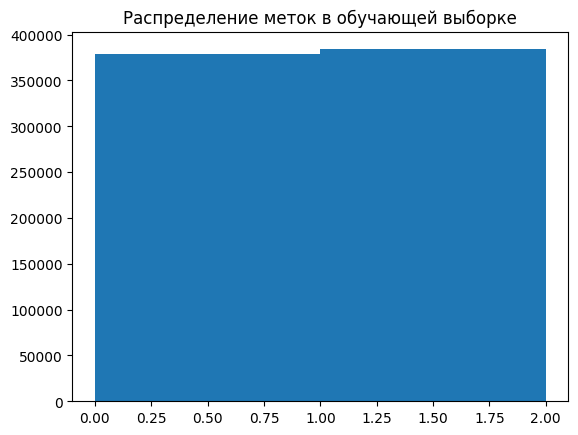

In [21]:
plt.hist(train_y, bins=np.arange(0, 3))
plt.title('Распределение меток в обучающей выборке');

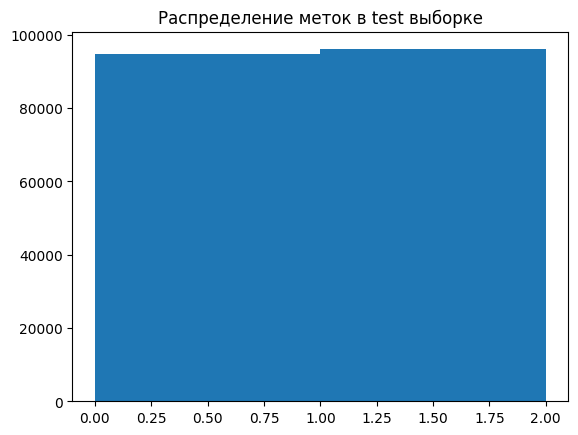

In [22]:
plt.hist(test_y, bins=np.arange(0, 3))
plt.title('Распределение меток в test выборке');

In [23]:
tt = tokenize(train_X.iloc[0])
tt

['фильтр',
 'акпп',
 'hyundai',
 'getz',
 '02-10/elantra',
 '1.8',
 '00-06/matrix',
 '1.6',
 '01-08/kia',
 'rio',
 '1.4',
 '05-11/cerato',
 '1.6',
 '04-06',
 'ремкомплект',
 'двигателя',
 'мототехники']

In [24]:
v = TfidfVectorizer(tokenizer=tokenize)

v_tr_X = v.fit_transform(train_X)

v_tr_X.shape

(763013, 382908)

In [25]:
v_tr_X[0].toarray()[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [26]:
MAX_DF = 0.9
MIN_COUNT = 1

target_pipeline = Pipeline((('vect', TfidfVectorizer(tokenizer=tokenize,
                                                      max_df=MAX_DF,
                                                      min_df=MIN_COUNT)),
                             ('cls', LogisticRegression(max_iter=150))))
target_pipeline.fit(train_X, train_y)

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.9,
                                 tokenizer=<function tokenize at 0x176f04040>)),
                ('cls', LogisticRegression(max_iter=150))])

In [27]:
target_train_pred = target_pipeline.predict_proba(train_X)
target_test_pred = target_pipeline.predict_proba(test_X)

train_loss = F.cross_entropy(torch.from_numpy(target_train_pred), torch.tensor(train_y.values))
print('Среднее значение функции потерь на обучении', float(train_loss))

test_loss = F.cross_entropy(torch.from_numpy(target_test_pred), torch.tensor(test_y.values))
print('Среднее значение функции потерь на валидации', float(test_loss))

Среднее значение функции потерь на обучении 0.5241051692052991
Среднее значение функции потерь на валидации 0.5366715103892162


In [28]:
print('Доля верных ответов', accuracy_score(train_y, target_train_pred.argmax(-1)))
print()

print('Доля верных ответов', accuracy_score(test_y, target_test_pred.argmax(-1)))

Доля верных ответов 0.8129193080589715

Доля верных ответов 0.7871918806420836


https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

average{‘micro’, ‘macro’, ‘samples’, ‘weighted’, ‘binary’} or None, default=’binary’
This parameter is required for multiclass/multilabel targets. If None, the metrics for each class are returned. Otherwise, this determines the type of averaging performed on the data:

'binary'
:
Only report results for the class specified by pos_label. This is applicable only if targets (y_{true,pred}) are binary.

'micro'
:
Calculate metrics globally by counting the total true positives, false negatives and false positives.

'macro'
:
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

'weighted'
:
Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

'samples'
:
Calculate metrics for each instance, and find their average (only meaningful for multilabel classification where this differs from accuracy_score).

In [29]:
print('f1_score', f1_score(train_y, target_train_pred.argmax(-1)))
print()

print('f1_score', f1_score(test_y, target_test_pred.argmax(-1)))

f1_score 0.795383753115938

f1_score 0.7666314070871755


https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

average{‘micro’, ‘macro’, ‘samples’, ‘weighted’} or None, default=’macro’
If None, the scores for each class are returned. Otherwise, this determines the type of averaging performed on the data. Note: multiclass ROC AUC currently only handles the ‘macro’ and ‘weighted’ averages. For multiclass targets, average=None is only implemented for multi_class='ovr' and average='micro' is only implemented for multi_class='ovr'.

'micro'
:
Calculate metrics globally by considering each element of the label indicator matrix as a label.

'macro'
:
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

'weighted'
:
Calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label).

'samples'
:
Calculate metrics for each instance, and find their average.

Will be ignored when y_true is binary.


multi_class{‘raise’, ‘ovr’, ‘ovo’}, default=’raise’
Only used for multiclass targets. Determines the type of configuration to use. The default value raises an error, so either 'ovr' or 'ovo' must be passed explicitly.

'ovr'
:
Stands for One-vs-rest. Computes the AUC of each class against the rest [3] [4]. This treats the multiclass case in the same way as the multilabel case. Sensitive to class imbalance even when average == 'macro', because class imbalance affects the composition of each of the ‘rest’ groupings.

'ovo'
:
Stands for One-vs-one. Computes the average AUC of all possible pairwise combinations of classes [5]. Insensitive to class imbalance when average == 'macro'.

In [30]:
print('roc_auc_score', roc_auc_score(train_y, target_train_pred.argmax(-1)))
print()

print('roc_auc_score', roc_auc_score(test_y, target_test_pred.argmax(-1)))

roc_auc_score 0.8134905000857244

roc_auc_score 0.787777297067979


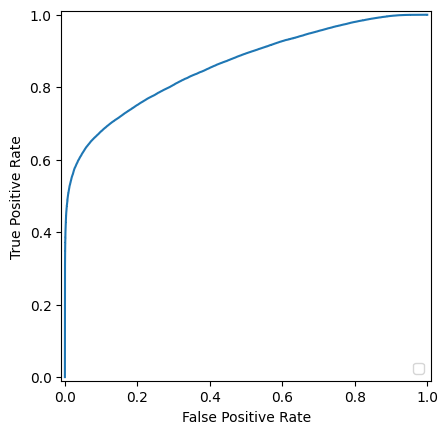

In [31]:
fpr, tpr, _ = roc_curve(test_y, target_test_pred[:, 1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

Tests

In [32]:
df_test[df_test['target'] == 1].head(1)

,main_photo,name,type,category_l2,category_l4,is_markup,target,stratify_column,data
7809846,https://cdn1.ozone.ru/s3/multimedia-t/63327116...,"Защитный кейс (бокс, чехол) для карт памяти SD...",Комплект фотоаксессуаров,,,False,1,nan_False_1,"Защитный кейс (бокс, чехол) для карт памяти SD..."


In [33]:
df_test[df_test['target'] == 0].head(1)

,main_photo,name,type,category_l2,category_l4,is_markup,target,stratify_column,data
50527,https://cdn1.ozone.ru/s3/multimedia-1-3/696992...,"Ножницы Волна , 9"", 23 см, шаг - 18 мм, цвет ч...",Пирог,Хобби и творчество,Набор для шитья одежды,True,0,Хобби и творчество_True_0,"Ножницы Волна , 9"", 23 см, шаг - 18 мм, цвет ч..."


In [34]:
text = df_test.loc[7809846]['data']
text

'Защитный кейс (бокс, чехол) для карт памяти SD, MicroSD   Комплект фотоаксессуаров'

In [35]:
text2 = df_test.loc[50527]['data']
text2

'Ножницы Волна , 9", 23 см, шаг - 18 мм, цвет чёрный Хобби и творчество Набор для шитья одежды Пирог'

In [36]:
df_test.loc[7809846]['main_photo']

'https://cdn1.ozone.ru/s3/multimedia-t/6332711633.jpg'

In [37]:
df_test.loc[50527]['main_photo']

'https://cdn1.ozone.ru/s3/multimedia-1-3/6969923031.jpg'

In [38]:
text_1 = [df_test.loc[idx]['data'] for idx in df_test[df_test['target'] == 1].head(5).index]
text_1

['Защитный кейс (бокс, чехол) для карт памяти SD, MicroSD   Комплект фотоаксессуаров',
 'Кружка латте керамическая большая для чая и кофе с прикольным принтом "Осень посудина с угощениями на пикнике среди яркой листвы" 480 мл. Дом и сад Кружка Кружка',
 'Угольник-переходник ROMMER ВПр-НР, 15х1_2, из нержавеющей стали прессовой (2шт.) Строительство и ремонт Фитинг сантехнический Удлинитель сантехнический',
 'Интерьерная картина "Кирпичи в руинах древней цивилизации" на холсте 240х90 см. с подвесами Дом и сад Картина Картина',
 'Бра LED Строительство и ремонт Настенный светильник Подсветка для картин']

In [39]:
text_0 = [df_test.loc[idx]['data'] for idx in df_test[df_test['target'] == 0].head(5).index]
text_0

['Ножницы Волна , 9", 23 см, шаг - 18 мм, цвет чёрный Хобби и творчество Набор для шитья одежды Пирог',
 'Аксельбант офицерский желтый   Станок для натягивания проволоки в рамке для пчел',
 '15 шт. Мелки школьные Гамма, цветные, 10шт., мягкие, круглые, картонная упаковка, европодвес Канцелярские товары Мелки Проживание в пансионате',
 'Таблетированная соль Rockmelt 4-в-1, 20 кг.   Украшение настольное интерьерное',
 'Одеяло детское Baby Nice "Божьи коровки", стеганое, цвет: красный, 105 см x 140 см. Q0412123   Корзина плетеная']

In [40]:
pred = pd.Series(text_0 + text_1, name='data')
pred

0    Ножницы Волна , 9", 23 см, шаг - 18 мм, цвет ч...
1    Аксельбант офицерский желтый   Станок для натя...
2    15 шт. Мелки школьные Гамма, цветные, 10шт., м...
3    Таблетированная соль Rockmelt 4-в-1, 20 кг.   ...
4    Одеяло детское Baby Nice "Божьи коровки", стег...
5    Защитный кейс (бокс, чехол) для карт памяти SD...
6    Кружка латте керамическая большая для чая и ко...
7    Угольник-переходник ROMMER ВПр-НР, 15х1_2, из ...
8    Интерьерная картина "Кирпичи в руинах древней ...
9    Бра LED Строительство и ремонт Настенный свети...
Name: data, dtype: object

In [41]:
proba = target_pipeline.predict_proba(pred)
proba.argmax(-1) # 0, 0, 0, 0, 0, 1, 1, 1, 1, 1

array([0, 0, 0, 1, 0, 0, 1, 1, 1, 1])

In [42]:
with open('target_pipeline.pkl', 'wb') as file:
        pickle.dump(target_pipeline, file)


In [43]:
types = pd.Series(pd.concat([df_train, df_test])['type'].value_counts().index)
types.to_csv('types.csv')
types

0                                  Картина
1                                 Фотообои
2                                   Матрас
3                                   Постер
4                  Проживание в пансионате
                       ...                
20226    Вешалка для сушки хоккейной формы
20227                    Тейп для боулинга
20228         Ремень для внедорожной маски
20229                        Сгон для труб
20230                       Чехол для лука
Name: type, Length: 20231, dtype: object